## Parameter estimation with PINNs

The following corresponds to the second approach of PINNs, data-driven discovery of partial differential equations, where they are used to estimate parameters of equations. We will revisit the diffusion equation, studied in a previous notebook of this series, however this time in the parametric form

$$ \frac{\partial u\left(t,x\right)}{\partial t} - D \frac{\partial^2 u\left(t,x\right)}{\partial x^2} = 0, \hspace{10mm} \left(t,x\right) \in [0,1]\times\left[0,1\right], $$

subject to the following initial and boundary conditions

$$ u\left(t=0,x\right) = \sin\left(\pi x\right), \hspace{10mm} x \in \left[0,1\right], $$

$$ u\left(t,x=0\right) = u\left(t,x=1\right) = 0, \hspace{10mm} t \in \left[0,1\right]. $$

This time, the $D$ parameter does not assume a fixed value, since it is the parameter to be estimated.

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import optax
import flax.linen as nn

from typing import Sequence, Callable

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

Instead of imposing the IC/BCs through a PINN and solving the equation, we use a sample of points generated randomly in the domain $\left(t,x\right) \in \left[0,1\right]\times\left[0,1\right]$ from the exact solution. In a realistic scenario, these points could correspond to measurements from experiments, so we should also take into account the case of noisy data.

In [2]:
def analytic_u(t,x,D):
    return np.sin(np.pi*x)*np.exp(-D*(np.pi**2)*t)

In [3]:
def plot_initial(data):
    
    fig = plt.figure(figsize=(6,4))

    cmap = 'Spectral'
    
    t, x, u = data[:,[0]], data[:,[1]], data[:,[2]]

    plt.scatter(t, x, c=u, marker='x', vmin=0, vmax=1, cmap=cmap)

    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')

    plt.title(f'Training Dataset, N = {len(t)}')

    cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap))
    cbar.set_label(r'$u(t,x)$', rotation=90)

    plt.show()

def generate_dataset(N=1000, noise_percent=0.0, D=0.15, seed=420):
    # seed key for debugging
    np.random.seed(seed)

    # Domains of t and x
    tmin, tmax = 0.0, 1.0
    xmin, xmax = 0.0, 1.0

    t_vals = np.random.uniform(low=tmin,high=tmax,size=(N,1))
    x_vals = np.random.uniform(low=xmin,high=xmax,size=(N,1))

    u_vals = analytic_u(t=t_vals,x=x_vals,D=D)
    noise = np.random.normal(0, u_vals.std(), [N,1])*noise_percent
    u_vals += noise

    colloc = jnp.concatenate([t_vals,x_vals,u_vals],axis=1)

    return colloc, tmin, tmax, xmin, xmax

### Clean Data

At first, we generate a clean dataset, i.e. completely de-noised.

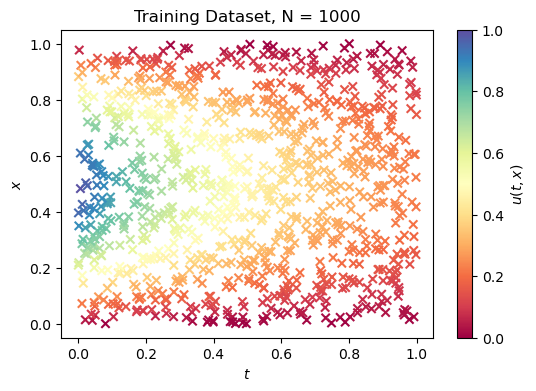

In [4]:
data, tmin, tmax, xmin, xmax = generate_dataset()
plot_initial(data)

We then define the relevant PINN equations using JAX + Flax, as in the previous notebooks. One key difference is that $D$ must now be a model parameter to be trained. In the JAX + Flax implementation, this can be done by inserting an additional $D$ parameter in the `MLP(nn.Module)` class, which is initialized at the value 1.0 and is trainable. It does not matter that $D$ is not used during the forward call of the $u$-NN, as long as the $u$-NN carries this information, so that it can be updated during backpropagation.

In [5]:
class MLP(nn.Module):
    features: Sequence[int]
    # We also add an initializer for the D parameter
    D_init: Callable = jax.nn.initializers.ones

    def setup(self):
        # include the D parameter during setup
        D = self.param("D", self.D_init, (1,))
        self.layers = [nn.Dense(features=feat, use_bias=True) for feat in self.features]
        
    def __call__(self, inputs):
        x = inputs
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if idx != len(self.layers)-1:
                x = jnp.tanh(x)
        return x

Note, also, that in this case we don't deal with collocation points and IC/BC points separately, so the `cond` and `colloc` arrays of the previous notebooks now correspond to a common array called `data`.

In [6]:
@jax.jit
def MSE(true,pred):
    return jnp.mean((true-pred)**2)
    
def PINN_f(t,x,D,ufunc):
    u_x = lambda t,x : jax.grad(lambda t,x : jnp.sum(ufunc(t,x)),1)(t,x)
    u_xx = lambda t,x : jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)(t,x)
    u_t = lambda t,x : jax.grad(lambda t,x : jnp.sum(ufunc(t,x)),0)(t,x)
    return u_t(t,x) - D*u_xx(t,x)
    
@jax.jit
def uNN(params,t,x):
    u = model.apply(params, jnp.concatenate((t,x),axis=1))
    return u

def loss_fun(params,data):
    t_c, x_c, u_c = data[:,[0]], data[:,[1]], data[:,[2]]
    ufunc = lambda t,x : uNN(params,t,x)
    
    # Find the value of D
    D = params["params"]["D"]
    
    mse_u = MSE(u_c,ufunc(t_c,x_c))
    mse_f = jnp.mean(PINN_f(t_c,x_c,D,ufunc)**2)
    
    return mse_f + mse_u

@jax.jit
def update(opt_state,params,data):
    # Get the gradient w.r.t to MLP params
    grads=jax.jit(jax.grad(loss_fun,0))(params, data)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Apply the update
    params = optax.apply_updates(params, updates)

    return opt_state, params

def init_process(feats):
    
    model = MLP(features=feats)

    key1, key2 = jax.random.split(jax.random.PRNGKey(420),num=2)

    dummy_in = jax.random.normal(key1, (2,))
    params = model.init(key2, dummy_in)

    lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    
    return model, params, optimizer, opt_state

def plot_results(T, X, Dcalc, results, analytic_results):
    fig, axes = plt.subplots(2, 1, figsize=(8,12))

    t_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    x_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]

    c1 = axes[0].pcolormesh(T, X, results, cmap='Spectral')
    axes[0].set(xlabel = r'$t$', ylabel = r'$x$', xticks=t_ticks, yticks=x_ticks)
    axes[0].set_title(f'PINN Solution of the PDE, with D = {Dcalc:.7f}')

    cbar1 = plt.colorbar(c1, ax=axes[0])
    cbar1.set_label(r'$u(t,x)$', rotation=90)

    c2 = axes[1].pcolormesh(T, X, abs(analytic_results-results), cmap='Spectral')
    axes[1].set(xlabel = r'$t$', ylabel = r'$x$', xticks=t_ticks, yticks=x_ticks)
    axes[1].set_title('Absolute difference between PINN and exact solution')

    cbar2 = plt.colorbar(c2, ax=axes[1])
    cbar2.set_label(r'$|{u_{exact}}(t,x) - u(t,x)|$', rotation=90)

    plt.show()

Initialization & training of the model.

In [7]:
features = [8, 8, 8, 8, 8, 8, 1]

model, params, optimizer, opt_state = init_process(features)

In [8]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,data)

    # print loss and epoch info
    if epoch%(1000) ==0:
        print(f'Epoch = {epoch},\tloss = {loss_fun(params,data):.3e}')

Epoch = 0,	loss = 2.717e-01
Epoch = 1000,	loss = 1.250e-04
Epoch = 2000,	loss = 3.971e-04
Epoch = 3000,	loss = 3.244e-05
Epoch = 4000,	loss = 2.144e-05
Epoch = 5000,	loss = 3.635e-04
Epoch = 6000,	loss = 4.932e-05
Epoch = 7000,	loss = 1.588e-05
Epoch = 8000,	loss = 2.502e-04
Epoch = 9000,	loss = 4.818e-05
Epoch = 10000,	loss = 3.506e-05
Epoch = 11000,	loss = 7.368e-06
Epoch = 12000,	loss = 7.237e-06
Epoch = 13000,	loss = 7.060e-06
Epoch = 14000,	loss = 6.824e-06
Epoch = 15000,	loss = 6.515e-06
Epoch = 16000,	loss = 6.119e-06
Epoch = 17000,	loss = 5.633e-06
Epoch = 18000,	loss = 5.071e-06
Epoch = 19000,	loss = 4.449e-06
CPU times: user 15.9 s, sys: 3.81 s, total: 19.7 s
Wall time: 17.6 s


In [9]:
Dcalc = params["params"]["D"][0]
D = 0.15
print(f"The real value of the parameter is D = {D}")
print(f"The calculated value for the parameter is D_calc = {Dcalc:.7f}.")
print(f"This corresponds to a {100*(Dcalc-D)/D:.5f}% error.")

The real value of the parameter is D = 0.15
The calculated value for the parameter is D_calc = 0.1500673.
This corresponds to a 0.04486% error.


As we can see, the PINN successfully identifies the value of the parameter with a relative error of < 0.1% ! As far as the solution of the equation is concerned, it can be seen below, along with the absolute difference from the analytic solution.

In [10]:
N_grid = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N_grid)
xspace = np.linspace(xmin, xmax, N_grid)
T, X = np.meshgrid(tspace, xspace)

results = uNN(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1)).reshape(N_grid,N_grid)
analytic_results = analytic_u(T.flatten().reshape(-1,1),X.flatten().reshape(-1,1),D).reshape(N_grid,N_grid)

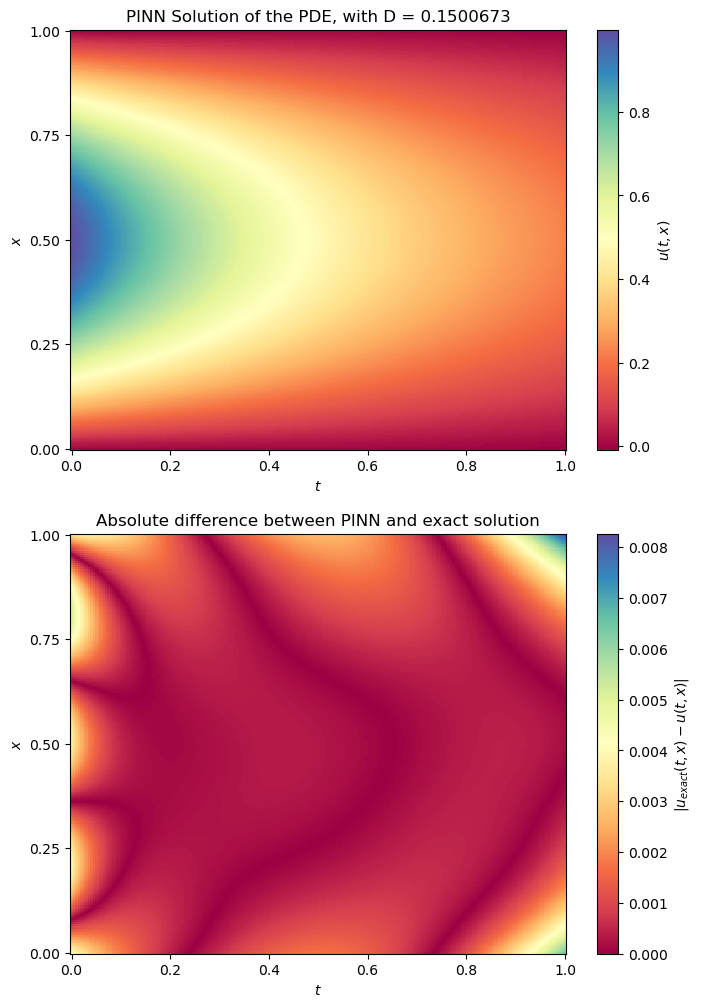

In [11]:
plot_results(T, X, Dcalc, results, analytic_results)

### Noisy Data

All that is now left to do, is to repeat these experiments with noisy data. For this purpose, we generate a dataset with 5% noise, depicted in the figure below.

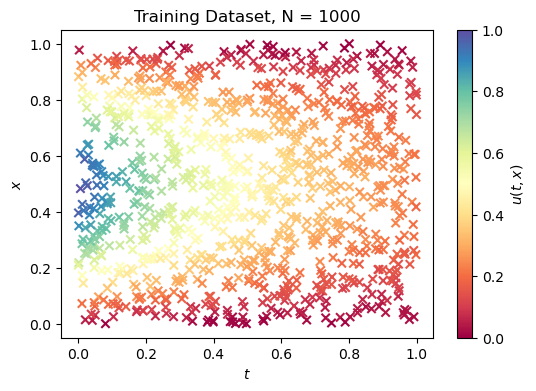

In [12]:
noisy_data, tmin, tmax, xmin, xmax = generate_dataset(noise_percent=0.05)
plot_initial(noisy_data)

As far as the initialization and training are concerned:

In [13]:
features = [8, 8, 8, 8, 8, 8, 1]

model, params, optimizer, opt_state = init_process(features)

In [14]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,noisy_data)

    # print loss and epoch info
    if epoch%(1000) ==0:
        print(f'Epoch = {epoch},\tloss = {loss_fun(params,noisy_data):.3e}')

Epoch = 0,	loss = 2.720e-01
Epoch = 1000,	loss = 1.855e-04
Epoch = 2000,	loss = 1.434e-04
Epoch = 3000,	loss = 1.354e-04
Epoch = 4000,	loss = 1.600e-04
Epoch = 5000,	loss = 1.652e-04
Epoch = 6000,	loss = 1.646e-04
Epoch = 7000,	loss = 1.512e-04
Epoch = 8000,	loss = 1.670e-04
Epoch = 9000,	loss = 2.625e-04
Epoch = 10000,	loss = 1.544e-04
Epoch = 11000,	loss = 1.235e-04
Epoch = 12000,	loss = 1.231e-04
Epoch = 13000,	loss = 1.228e-04
Epoch = 14000,	loss = 1.226e-04
Epoch = 15000,	loss = 1.223e-04
Epoch = 16000,	loss = 1.219e-04
Epoch = 17000,	loss = 1.214e-04
Epoch = 18000,	loss = 1.209e-04
Epoch = 19000,	loss = 1.202e-04
CPU times: user 12.7 s, sys: 3.05 s, total: 15.7 s
Wall time: 14.8 s


In [15]:
Dcalc_noisy = params["params"]["D"][0]
D = 0.15
print(f"The real value of the parameter is D = {D}")
print(f"The calculated value for the parameter is D_calc = {Dcalc_noisy:.7f}.")
print(f"This corresponds to a {100*(Dcalc_noisy-D)/D:.5f}% error.")

The real value of the parameter is D = 0.15
The calculated value for the parameter is D_calc = 0.1497423.
This corresponds to a -0.17182% error.


As was expected, the error in the parameter estimation increased, however the final result remains a very good approximation of the real parameter.

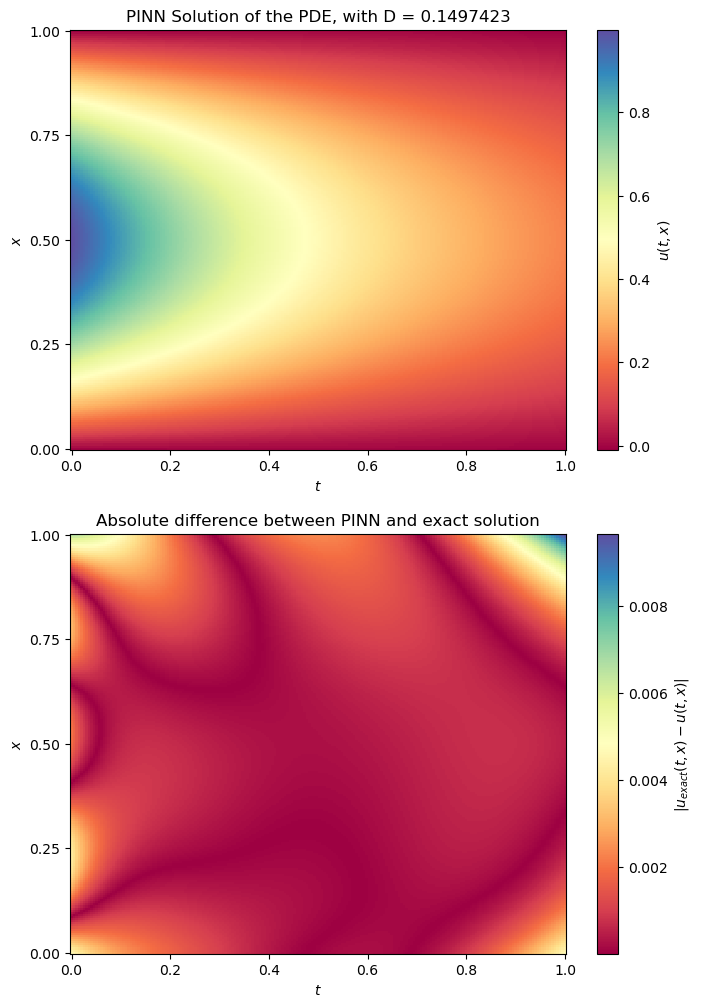

In [16]:
results_noisy = uNN(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1)).reshape(N_grid,N_grid)
plot_results(T, X, Dcalc_noisy, results_noisy, analytic_results)

### Improvements by increasing input volume or changing network

Closing the present analysis of parameter estimation, it is worth repeating the experiment for the noisy data, this time:

[a] keeping the same NN model and increasing the number of input data and

[b] using a better MLP with double neurons per hidden layer and 2 additional hidden layers and keeping the same volume of input data.

Let's try the same procedure, this time using 2000 points instead of 1000.

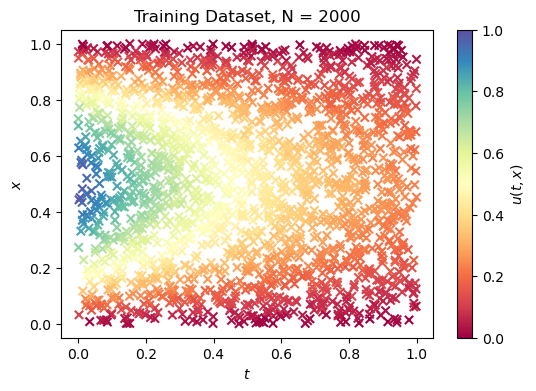

In [17]:
big_noisy_data, tmin, tmax, xmin, xmax = generate_dataset(N=2000,noise_percent=0.05)
plot_initial(big_noisy_data)

In [18]:
features = [8, 8, 8, 8, 8, 8, 1]

model, params, optimizer, opt_state = init_process(features)

In [19]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,big_noisy_data)

    # print loss and epoch info
    if epoch%(1000) == 0:
        print(f'Epoch = {epoch},\tloss = {loss_fun(params,big_noisy_data):.3e}')

Epoch = 0,	loss = 2.537e-01
Epoch = 1000,	loss = 2.050e-04
Epoch = 2000,	loss = 1.567e-04
Epoch = 3000,	loss = 1.523e-04
Epoch = 4000,	loss = 1.559e-04
Epoch = 5000,	loss = 1.678e-04
Epoch = 6000,	loss = 3.498e-04
Epoch = 7000,	loss = 1.889e-04
Epoch = 8000,	loss = 2.010e-04
Epoch = 9000,	loss = 1.739e-04
Epoch = 10000,	loss = 1.762e-04
Epoch = 11000,	loss = 1.317e-04
Epoch = 12000,	loss = 1.316e-04
Epoch = 13000,	loss = 1.315e-04
Epoch = 14000,	loss = 1.313e-04
Epoch = 15000,	loss = 1.311e-04
Epoch = 16000,	loss = 1.309e-04
Epoch = 17000,	loss = 1.306e-04
Epoch = 18000,	loss = 1.302e-04
Epoch = 19000,	loss = 1.297e-04
CPU times: user 19.1 s, sys: 6.77 s, total: 25.8 s
Wall time: 23.1 s


In [20]:
Dcalc_noisy = params["params"]["D"][0]
D = 0.15
print(f"The real value of the parameter is D = {D}")
print(f"The calculated value for the parameter is D_calc = {Dcalc_noisy:.7f}.")
print(f"This corresponds to a {100*(Dcalc_noisy-D)/D:.5f}% error.")

The real value of the parameter is D = 0.15
The calculated value for the parameter is D_calc = 0.1498923.
This corresponds to a -0.07180% error.


Let us now try with the initial volume of noisy data, but with a wider and deeper network.

In [21]:
features_2 = [16, 16, 16, 16, 16, 16, 16, 16, 1]

model, params, optimizer, opt_state = init_process(features_2)

In [22]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,noisy_data)

    # print loss and epoch info
    if epoch%(1000) == 0:
        print(f'Epoch = {epoch},\tloss = {loss_fun(params,noisy_data):.3e}')

Epoch = 0,	loss = 1.011e-01
Epoch = 1000,	loss = 2.083e-04
Epoch = 2000,	loss = 1.554e-04
Epoch = 3000,	loss = 1.276e-04
Epoch = 4000,	loss = 1.234e-04
Epoch = 5000,	loss = 1.753e-04
Epoch = 6000,	loss = 2.733e-04
Epoch = 7000,	loss = 1.298e-04
Epoch = 8000,	loss = 1.182e-04
Epoch = 9000,	loss = 1.181e-04
Epoch = 10000,	loss = 1.196e-04
Epoch = 11000,	loss = 1.195e-04
Epoch = 12000,	loss = 1.194e-04
Epoch = 13000,	loss = 1.193e-04
Epoch = 14000,	loss = 1.191e-04
Epoch = 15000,	loss = 1.189e-04
Epoch = 16000,	loss = 1.186e-04
Epoch = 17000,	loss = 1.183e-04
Epoch = 18000,	loss = 1.179e-04
Epoch = 19000,	loss = 1.175e-04
CPU times: user 21.8 s, sys: 4.44 s, total: 26.2 s
Wall time: 23.4 s


In [23]:
Dcalc_noisy = params["params"]["D"][0]
D = 0.15
print(f"The real value of the parameter is D = {D}")
print(f"The calculated value for the parameter is D_calc = {Dcalc_noisy:.7f}.")
print(f"This corresponds to a {100*(Dcalc_noisy-D)/D:.5f}% error.")

The real value of the parameter is D = 0.15
The calculated value for the parameter is D_calc = 0.1497578.
This corresponds to a -0.16148% error.


It becomes evident that increasing the volume of the available initial data yields significantly better results (relative error reduced by more than half) compared to "enchancing" the used network. This means that when tackling such problems it is more important to be able to provide data of a considerable quality and quantity, than be able to deploy complex NN algorithms.